In [223]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from time import time
warnings.filterwarnings('ignore')

Zadanie 1 - badanie klasyfikatoróœ

1.

In [224]:
X,y = make_classification(n_samples=1000, n_classes=2, n_clusters_per_class=2, n_features=2, n_informative=2, n_redundant=0, random_state=535)
X.shape

(1000, 2)

2.

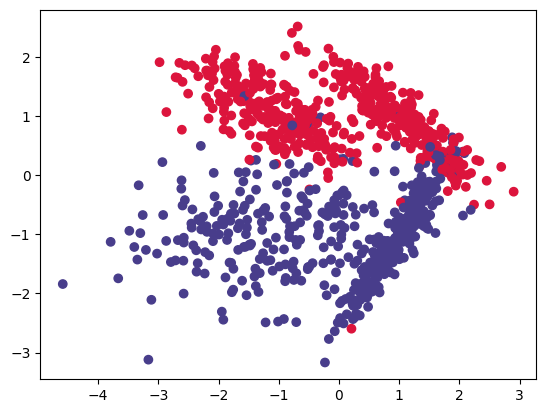

In [225]:
colormap = np.array(['darkslateblue', 'crimson'])
plt.scatter(X[:, 0], X[:, 1], c=colormap[y]);

3.

In [226]:
classifiers = [
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    KNeighborsClassifier(),
    SVC(probability=True),
    DecisionTreeClassifier()
]

In [227]:
df = pd.DataFrame(columns=["classifier", "accuracy_score", "recall_score", "precision_score",
                           "F1_score", "roc_auc", "train_time", "test_time"])

In [81]:
# Do krzywej dyskryminacyjnej


In [228]:
y_test_list = []
y_pred_proba_list = []
auc_list = []

# do krzywej dyskryminacyjnej
X_test_list = []
x_ = np.linspace(np.amin(X[:, 0]), np.amax(X[:, 0]))
y_ = np.linspace(np.amin(X[:, 1]), np.amax(X[:, 1]))
xv, yv = np.meshgrid(x_, y_)
mesh_flat = np.vstack((xv.ravel(), yv.ravel())).T
Z_list = []

for clf in classifiers:

    accuracy_list = []
    recall_list = []
    precision_list = []
    F1_list = []
    roc_auc_list = []
    test_time_list = []
    train_time_list = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        start_time = time()
        clf.fit(X_train, y_train)
        train_time_list.append(time() - start_time)

        start_time = time()
        y_pred = clf.predict(X_test)
        test_time_list.append(time() - start_time)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        F1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        accuracy_list.append(accuracy)
        recall_list.append(recall)
        precision_list.append(precision)
        F1_list.append(F1)
        roc_auc_list.append(roc_auc)

        if i == 99:
            # do ROC
            y_test_list.append(y_test)
            y_pred_proba = clf.predict_proba(X_test)[:, 1]
            y_pred_proba_list.append(y_pred_proba)
            auc_list.append(roc_auc)

            # do krzywej dyskryminacyjnej
            X_test_list.append(X_test)
            Z = clf.predict(mesh_flat)
            Z = Z.reshape(xv.shape)
            Z_list.append(Z)


    classifier = clf.__class__.__name__
    accuracy = np.mean(accuracy_list)
    recall = np.mean(recall_list)
    precision = np.mean(precision_list)
    F1 = np.mean(F1_list)
    train_time = np.mean(train_time_list)
    test_time = np.mean(test_time_list)
    roc_auc = np.mean(roc_auc_list)
    classifier_name = clf.__class__.__name__
    
    df = df.append({
        'classifier': classifier_name,
        'accuracy_score': accuracy,
        'recall_score': recall,
        'precision_score': precision,
        'F1_score': F1,
        'roc_auc': roc_auc,
        'train_time': train_time,
        'test_time': test_time
    }, ignore_index=True)


In [229]:
df = df.set_index('classifier')
df

,accuracy_score,recall_score,precision_score,F1_score,roc_auc,train_time,test_time
classifier,,,,,,,
GaussianNB,0.933567,0.946356,0.922813,0.934197,0.933762,0.000530,0.000140
QuadraticDiscriminantAnalysis,0.945633,0.967211,0.928763,0.947427,0.945352,0.000372,0.000128
KNeighborsClassifier,0.949367,0.961222,0.939548,0.950066,0.949332,0.000460,0.004558
SVC,0.951500,0.985565,0.923588,0.953439,0.951232,0.010211,0.001078
DecisionTreeClassifier,0.936267,0.939751,0.932957,0.936096,0.936312,0.000897,0.000090


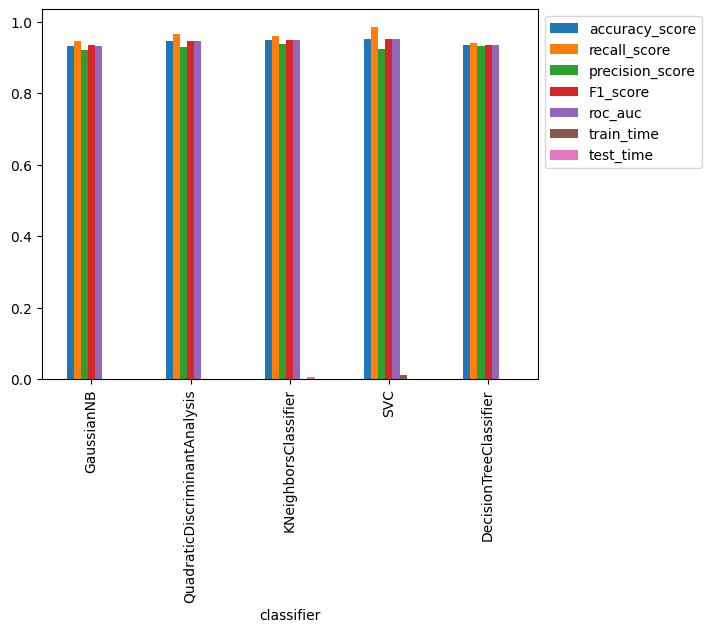

In [230]:
df.plot(kind='bar', rot=90).legend(bbox_to_anchor=(1, 1));


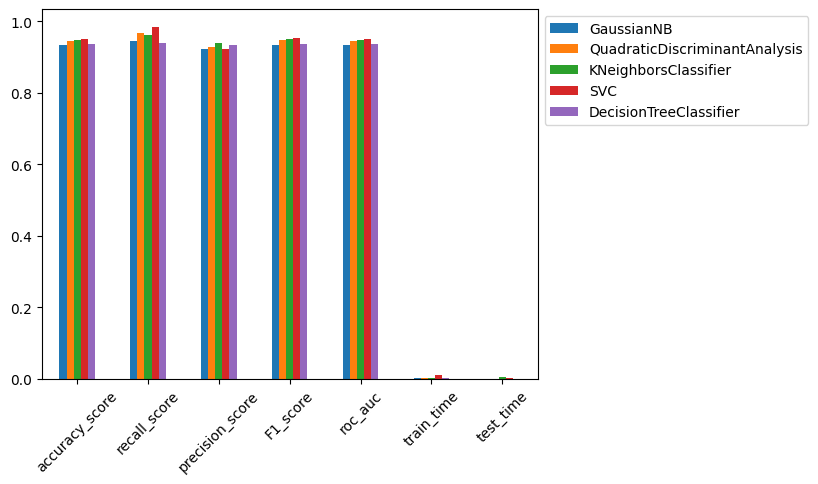

In [231]:
df = df.T
df.plot(kind='bar', rot=45).legend(bbox_to_anchor=(1, 1));


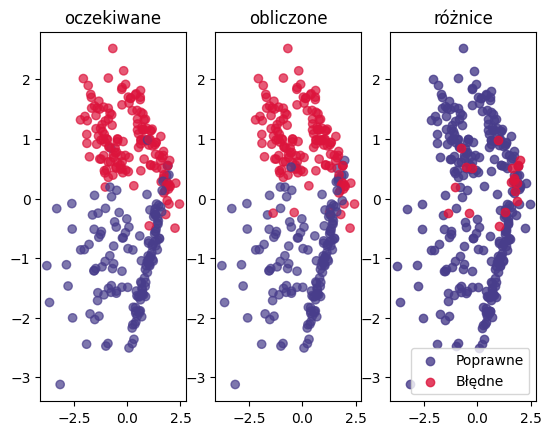

In [232]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.scatter(X_test[:, 0], X_test[:, 1], c=colormap[y_test], alpha=0.7)
ax2.scatter(X_test[:, 0], X_test[:, 1], c=colormap[y_pred], alpha=0.7)

correct = X_test[y_test == y_pred]
incorrect = X_test[y_test != y_pred]

ax3.scatter(correct[:, 0], correct[:, 1], c=colormap[0], alpha=0.8, label="Poprawne")
ax3.scatter(incorrect[:, 0], incorrect[:, 1], c=colormap[1], alpha=0.8, label="Błędne")
ax3.legend()

ax1.set_title('oczekiwane')
ax2.set_title('obliczone')
ax3.set_title('różnice');

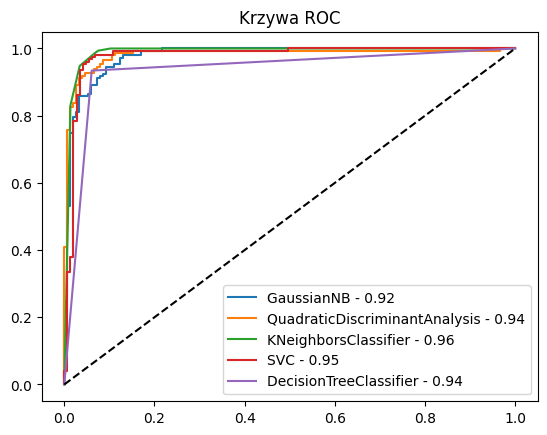

In [233]:
for i in range(len(classifiers)):
    y_test = y_test_list[i]
    y_pred_proba = y_pred_proba_list[i]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr, label=f"{classifiers[i].__class__.__name__} - {round(auc_list[i], 2)}")

plt.plot([0, 1], [0, 1], linestyle='--', color='k')
plt.title("Krzywa ROC")
plt.legend();

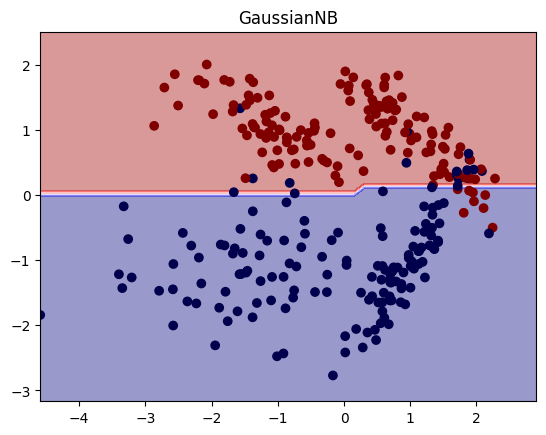

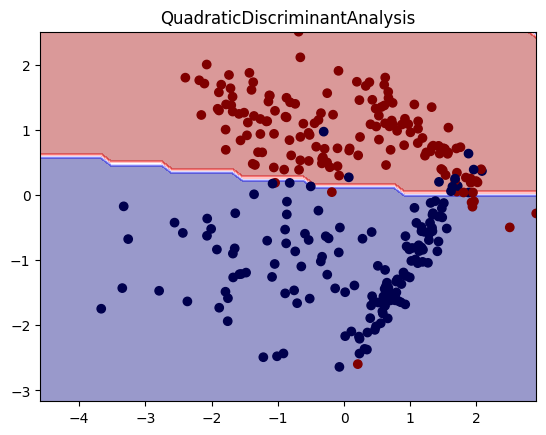

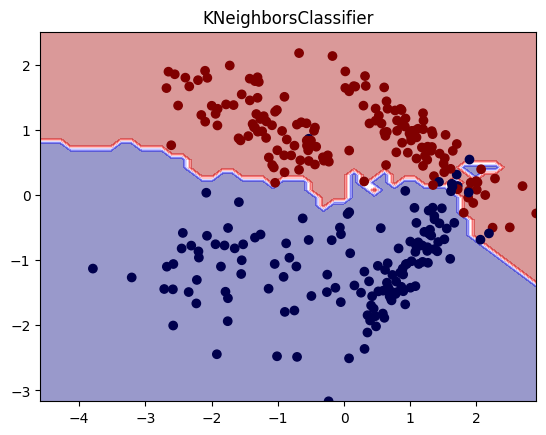

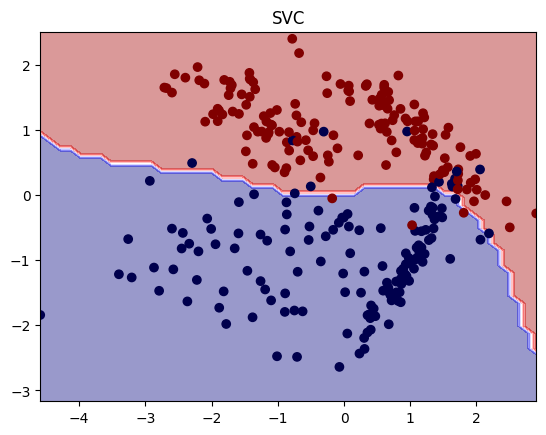

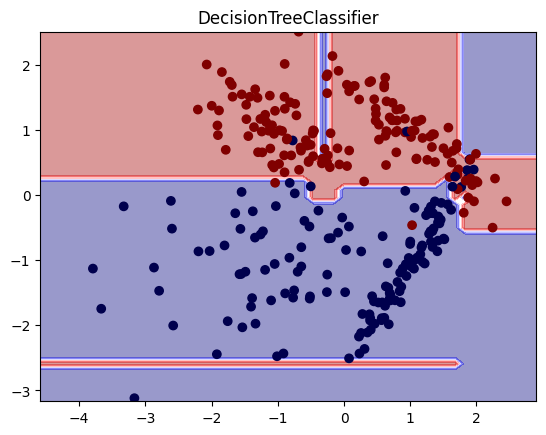

In [282]:
for i in range(len(classifiers)):
    plt.contourf(xv, yv, Z_list[i], cmap='seismic', alpha=.4)
    # plt.contour(xv, yv, Z_list[i])
    plt.scatter(X_test_list[i][:, 0], X_test_list[i][:, 1], cmap='seismic', c=y_test_list[i])
    plt.title(classifiers[i].__class__.__name__)
    plt.show()

# plt.contour(xv, yv, Z_list[4])
# plt.scatter(X_test_list[4][:, 0], X_test_list[4][:, 1], c=colormap[y_test_list[4]])
